# Deep Learning (APPROF) - Convolutional Neural Network (CNN) Problem Resolution

## Team Members:

- Filip Orlikowski, 1242389
- Filippo Ianniello, 1242315
- Olivia Puig, 1242352

## Dataset Description:

The dataset used for this problem contains images of approximately 960 unique **plants** belonging to **12 species** at several growth stages.
The list of species is as follows:
- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet

## Objective:

The objective of this problem is to develop a deep learning model, using a Convolutional Neural Network, aimed at classifying the various species of plant seedlings based on their images.

It is expected that the accuracy for each species, on average, exceeds 80%, and recall & precision must also be above 70%. Furthermore, the following questions, will be addressed during the model development:
- What is the impact of different filters, strides, padding, and pooling methods on the model's performance?
- What is the result of the convolution of a specific layer using example input images? What insights can be derived from it?
- What happens to the model performance when data agumentation is applied?
- Is there overfitting in the model? If yes how to solve it?
- What happens to the model results with and without a pre-trained network (e.g. Resnet50)?

## Solution:

In [91]:
from kaggle.api.kaggle_api_extended import KaggleApi
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Input
import time
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import cv2
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import plotly.subplots as sp
import plotly.graph_objects as go
import seaborn as sns
import os
import random
from PIL import Image
import nbformat as nb

### Dataset Importing
To download the dataset we used the KaggleAPI. We created a **Kaggle api Token** and set it up by creating a .json file in the following path of our system: ~/.kaggle/kaggle.json
The kaggle.json file had to look like this:

```python
{
   "username": "your_username",
   "key": "your_key"
}

In [72]:
dataset_path = './plant_seedlings'                     # Path to download the dataset
if not os.path.exists(dataset_path):
    if(not os.path.exists('kaggle.json')):
        print("Please place your kaggle.json file in the current directory.")
        exit()

    # Initialize the Kaggle API
    api = KaggleApi()
    api.authenticate()

    competition_name = 'plant-seedlings-classification'     # Name of the Kaggle competition

    # Download the competition dataset
    api.competition_download_files(competition_name, path=dataset_path)
    print(f"Dataset downloaded to {dataset_path}")

    # Unzip the dataset downloaded
    with zipfile.ZipFile(f'{dataset_path}/{competition_name}.zip', 'r') as zip_ref:
        zip_ref.extractall(dataset_path)

    print("Dataset extracted.")
else:
    print(f"Dataset already exists at {dataset_path}")

Dataset already exists at ./plant_seedlings


### Dataset Exploration

The dataset downloaded had the following folders:
- train, that contained the training set, with plant species organized by folder
- test, that contained the test set of images to predict

*Note*: we considered as our entire dataset only the samples that were in the train folder. The samples in the test folder weren't labelled, so not useful neither for training nor for testing.

In [73]:
train_dir = "./plant_seedlings/train"
#test_dir = "./plant_seedlings/test"

Before exploring the dataset we checked if there were **corrupted** or **unreadable** images inside the folders.
To quickly check whether an image file is corrupted, without fully decoding or loading the image data into memory, we used the *verify()* function in the Pillow (PIL) library. It detects things like truncated files, unexpected end of file, malformed headers, corrupted compression blocks.

In [74]:
def check_corrupted_images(dir_to_check):
    """
    Check for corrupted or unreadable images in a given directory.
    """
    corrupted_images = []
    for img_name in os.listdir(dir_to_check):
        img_path = os.path.join(dir_to_check, img_name)
        try:
            with Image.open(img_path) as img:
                img.verify()                    # Lightweight corruption check
        except Exception as e:
            corrupted_images.append(img_path)
            print(f"Error opening {img_path}: {e}")
    return corrupted_images

# Check for corrupted images in the training set
train_corrupted_images = []
for cls in os.listdir(train_dir):
    cls_dir = os.path.join(train_dir, cls)
    train_corrupted_images.extend(check_corrupted_images(cls_dir))

print(f"\nFound {len(train_corrupted_images)} corrupted or unreadable images.")
for img in train_corrupted_images:
    print(img)


Found 0 corrupted or unreadable images.


#### Class Distribution Analysis:
As first operation in exploring the dataset, we examined the distribution of samples across the different classes. This analysis is essential to determine if the dataset is balanced or exhibit class imbalance.

We found that the most frequent class ("Loose Silky-bent") has around 650 images, while the least frequent ("Maize") has a bit more than 200. So the most represented class contains nearly three times as many samples as the least represented one. While not extreme, this imbalance may influence model performance.

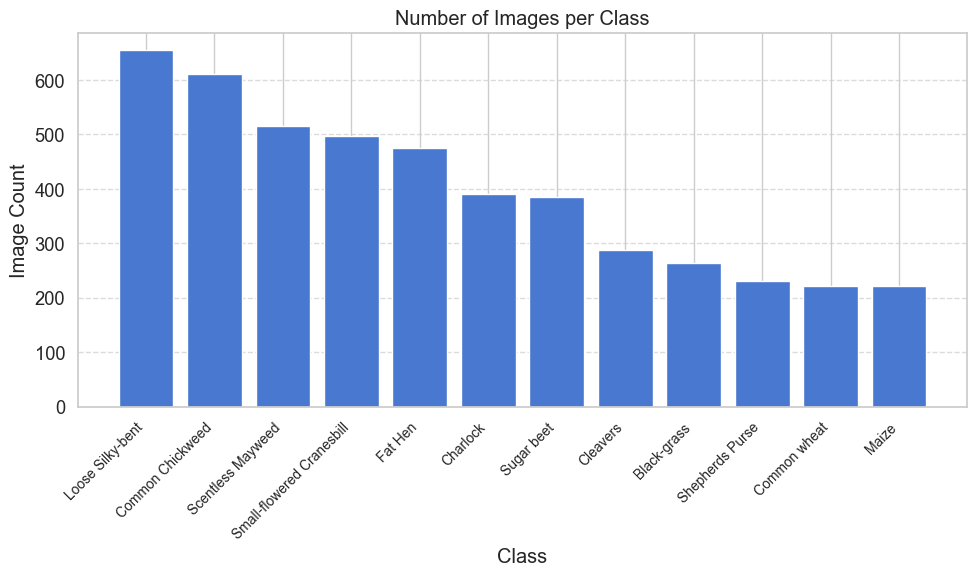

In [75]:
# Get list of subdirectories (classes) and count images
class_counts = {}
for cls_name in os.listdir(train_dir):
    cls_path = os.path.join(train_dir, cls_name)
    if os.path.isdir(cls_path):
        image_files = [f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f))]
        class_counts[cls_name] = len(image_files)

# Create DataFrame and sort by count
df_counts = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Image Count'])
df_counts.sort_values(by='Image Count', ascending=False, inplace=True)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(df_counts['Class'], df_counts['Image Count'])
ax.set_title("Number of Images per Class")
ax.set_xlabel("Class")
ax.set_ylabel("Image Count")
plt.xticks(rotation=45, ha='right', fontsize=10)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### Images Exploration per Class
As second operation, we wanted to understand how these different species of plant seeding looked like. Thus, for each class of the dataset, we visualized one random image of the training set that represented that class. We used *Plotly*, in order to have an **interactive output** where we can zoom, pan, and resize the view of the images.

In [76]:
# Get class names
class_names = df_counts['Class'].tolist()

# Grid size (customize as needed)
n_rows, n_cols = 3, 4
max_images = n_rows * n_cols

# Initialize Plotly subplot figure
fig = sp.make_subplots(rows=n_rows, cols=n_cols,
                       subplot_titles=class_names[:max_images],
                       vertical_spacing=0.05, horizontal_spacing=0.03)

# Load and add images
img_idx = 0
for row in range(1, n_rows + 1):
    for col in range(1, n_cols + 1):
        if img_idx >= len(class_names):
            break
        cls = class_names[img_idx]
        cls_path = os.path.join(train_dir, cls)
        image_files = [f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f))]
        if image_files:
            img_file = random.choice(image_files)
            img_path = os.path.join(cls_path, img_file)
            try:
                with Image.open(img_path) as img:
                    fig.add_trace(
                        go.Image(z=img),
                        row=row, col=col
                    )
            except Exception as e:
                print(f"Error loading image: {img_path} ({e})")
        img_idx += 1

# Update layout for cleaner visuals
fig.update_layout(
    height=800, width=1200,
    title_text="Example Images from Each Class (Interactive)",
    showlegend=False,
    title_x=0.5,
    margin=dict(l=10, r=10, t=60, b=10)
)

# Remove axes for all subplots
for i in range(1, n_rows * n_cols + 1):
    fig['layout'][f'xaxis{i}']['visible'] = False
    fig['layout'][f'yaxis{i}']['visible'] = False

fig.show()


#### Images Color Modes Check:
We inspected all images and tried to classify them into three types: true grayscale images (mode 'L'), pseudo-grayscale images (RGB images where R ≈ G ≈ B), and fully colored RGB images. 
It's important to understand the color mode of the images for a CNN for preprocessing decision or as well for the Input Consistency (wheter to have 1 or 3 channels as input).

In [77]:
def classify_image_color_mode(directory):
    """
    Classify valid images as RGB, grayscale, or pseudo-grayscale.
    """
    grayscale_L = []
    pseudo_grayscale = []
    rgb_images = []

    for img_name in os.listdir(directory):
        img_path = os.path.join(directory, img_name)
        try:
            with Image.open(img_path) as img:
                if img.mode == 'L':                     # Check if the image is in grayscale mode 'L'
                    grayscale_L.append(img_path)
                else:
                    img_rgb = img.convert('RGB')
                    np_img = np.array(img_rgb)

                    # Check if R, G, B channels are nearly equal (pseudo-grayscale)
                    if np.allclose(np_img[..., 0], np_img[..., 1], atol=2) and \
                       np.allclose(np_img[..., 1], np_img[..., 2], atol=2):
                        pseudo_grayscale.append(img_path)
                    else:
                        rgb_images.append(img_path)
        except Exception as e:
            print(f"Unexpected read error: {img_path} ({e})")
            continue

    return grayscale_L, pseudo_grayscale, rgb_images

train_grayscale_L = []
train_pseudo_gray = []
train_rgb = []

for cls in os.listdir(train_dir):
    cls_path = os.path.join(train_dir, cls)

    gL, pg, rgb = classify_image_color_mode(cls_path)
    train_grayscale_L.extend(gL)
    train_pseudo_gray.extend(pg)
    train_rgb.extend(rgb)

print(f"Grayscale (mode 'L'): {len(train_grayscale_L)}")
print(f"Pseudo-grayscale (RGB but R=G=B): {len(train_pseudo_gray)}")
print(f"Fully colored RGB images: {len(train_rgb)}")

Grayscale (mode 'L'): 0
Pseudo-grayscale (RGB but R=G=B): 0
Fully colored RGB images: 4750


We found out that all the Training set images were Fully colored RGB. So we then proceeded with the RGB analysis of the images.

#### RGB Channel Statistics
We analyzed the color characteristics (RGB) of all images in our training dataset. We examined the color distribution across all images by computing the **mean**, **standard deviation**, and **correlations** of the RGB channels. Finally, we plotted the **RGB Channel Mean Distribution**, in order to have some insight on the overall color balance of our dataset. This is helpful for preprocessing decision or to detect color bias.

*Note*: to make the data more interpretable and visually consistent, we normalized the RGB values of the images before the analysis 

Mean values per channel:
R    0.328815
G    0.289346
B    0.207304
dtype: float64
Standard deviation per channel:
R    0.034725
G    0.037108
B    0.050703
dtype: float64
Correlation between RGB channels:
          R         G         B
R  1.000000  0.882091  0.764380
G  0.882091  1.000000  0.858662
B  0.764380  0.858662  1.000000


<Figure size 1000x600 with 0 Axes>

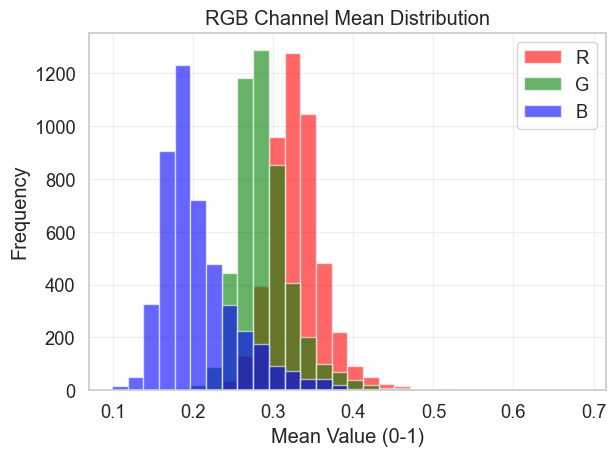

In [78]:
# Function to compute RGB means
def compute_rgb_means(image_path):
    try:
        img = Image.open(image_path).convert('RGB')
        img_np = np.array(img) / 255.0                  # Normalize pixel values to [0, 1]
        r_mean = np.mean(img_np[:, :, 0])
        g_mean = np.mean(img_np[:, :, 1])
        b_mean = np.mean(img_np[:, :, 2])
        return r_mean, g_mean, b_mean
    except:
        return None

# Collect the RGB means for all images
rgb_means = []

for cls in os.listdir(train_dir):
    cls_dir = os.path.join(train_dir, cls)
    for img_name in os.listdir(cls_dir):
        img_path = os.path.join(cls_dir, img_name)
        means = compute_rgb_means(img_path)
        if means:
            rgb_means.append(means)

# Convert to DataFrame
df_rgb = pd.DataFrame(rgb_means, columns=['R', 'G', 'B'])

# Check the mean and std dev of each color channel
mean_rgb = df_rgb.mean()
std_rgb = df_rgb.std()

print(f"Mean values per channel:\n{mean_rgb}")
print(f"Standard deviation per channel:\n{std_rgb}")

# Check correlations between channels (to see if any channel is too similar or too different)
correlation_matrix = df_rgb.corr()
print(f"Correlation between RGB channels:\n{correlation_matrix}")

# Plot histograms of R, G, B with matching colors
plt.figure(figsize=(10, 6))
df_rgb.plot(kind='hist', bins=30, alpha=0.6, color=['red', 'green', 'blue'])
plt.title('RGB Channel Mean Distribution')
plt.xlabel("Mean Value (0-1)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

From the graph we see that we should not encounter grayscale pictures. RGB colors are **distinclty distributed** with red channel resulting in the dominating color, with a mean value of 0.32, then we have green (presumably the plants color) with 0.29 and blue 0.21 which is a minority among the rgb set of colors.

#### Images Dimension Distribution
We analyzed and visualized the sizes (width and height) of all images in a training dataset. Specifically we scanned all images in our training set, and recorded their dimensions. Then we visualized their distribution of widths and heights using histograms. This is useful mainly for spotting outliers or to decide the resize strategies for the preprocessing.

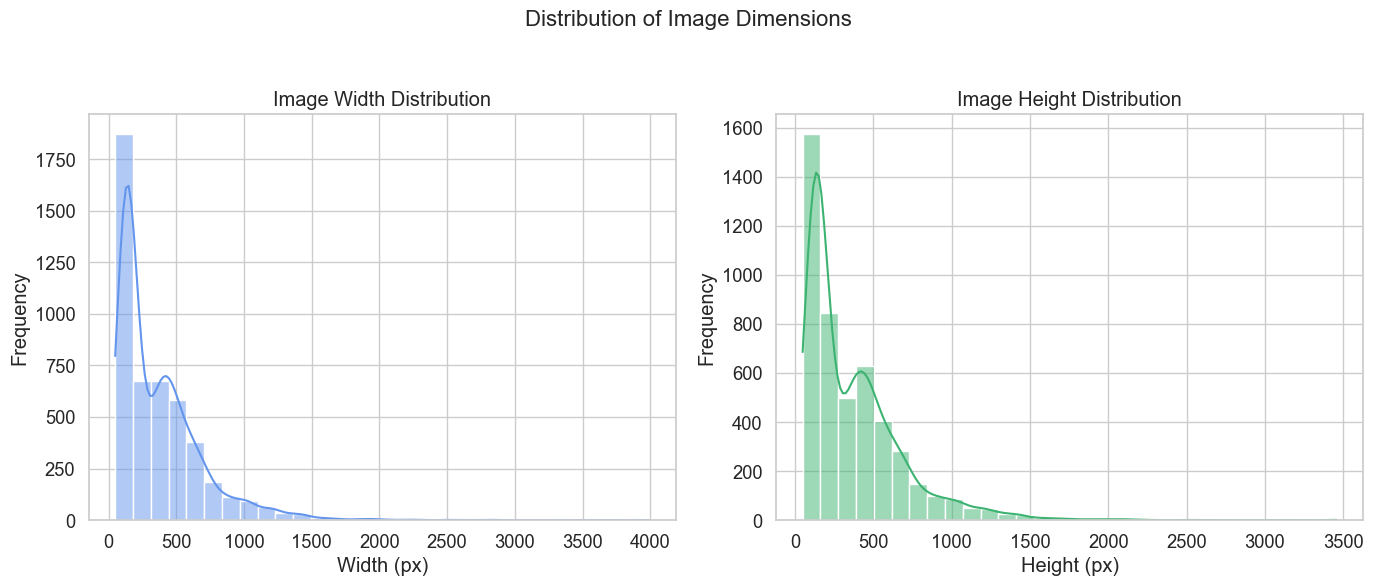

In [79]:
# Set Seaborn theme for cleaner aesthetics
sns.set_theme(style="whitegrid", palette="pastel", font_scale=1.2)

def collect_image_shapes(directory):
    """
    Collect the dimensions of images in a directory and return a list of tuples (width, height).
    """
    shapes = []
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if not os.path.isdir(class_path):
            continue
        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)
            try:
                with Image.open(image_path) as img:
                    shapes.append(img.size)                 # Tuple (width, height)
            except Exception as e:
                print(f"Could not open image: {image_path} ({e})")
    return shapes

# Collect image dimensions and create DataFrame
image_shapes = collect_image_shapes(train_dir)
df_shapes = pd.DataFrame(image_shapes, columns=['width', 'height'])

# Create figure with Seaborn plots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(data=df_shapes, x='width', bins=30, ax=axs[0], kde=True, color='cornflowerblue')
axs[0].set_title('Image Width Distribution')
axs[0].set_xlabel('Width (px)')
axs[0].set_ylabel('Frequency')

sns.histplot(data=df_shapes, x='height', bins=30, ax=axs[1], kde=True, color='mediumseagreen')
axs[1].set_title('Image Height Distribution')
axs[1].set_xlabel('Height (px)')
axs[1].set_ylabel('Frequency')

plt.suptitle('Distribution of Image Dimensions', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Histograms show that most images range from 100 to 600 pixels in width and height, with a few large outliers exceeding 1500 pixels. This **size variability** suggests that resizing or normalization is needed before using the data in the CNN.

#### Aspect Ratio Distribution of Images
We then visualized the distribution of aspect ratios (width divided by height) for the training set of images. 
(We included in the visualization also the kernel density estimate, KDE curve, to show the shape of the distribution)

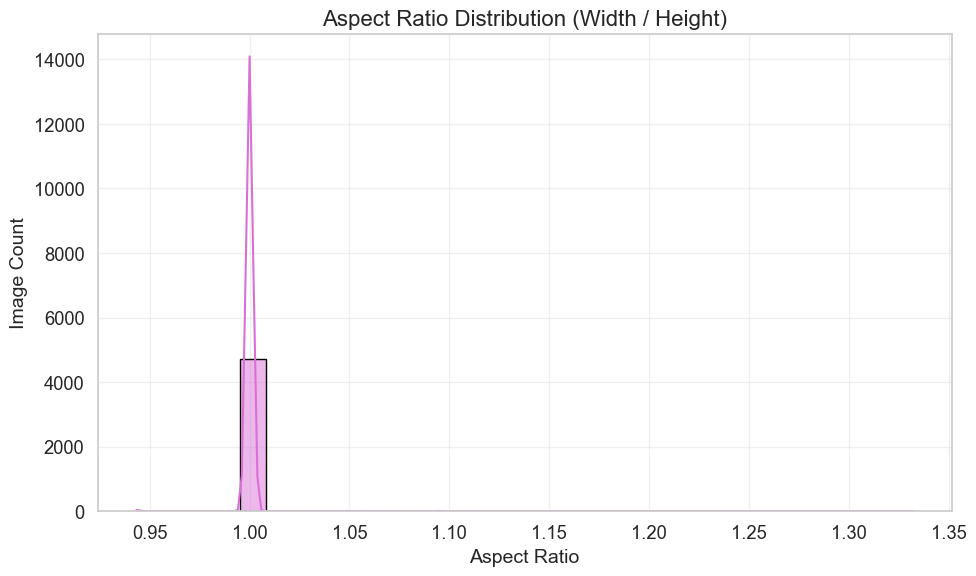

In [80]:
# Calculate Aspect Ratio
df_shapes['aspect_ratio'] = df_shapes['width'] / df_shapes['height']

# Set Seaborn style for improved visuals
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

plt.figure(figsize=(10, 6))

# Plot histogram of aspect ratios (with KDE)
sns.histplot(df_shapes['aspect_ratio'], bins=30, color='orchid', kde=True, edgecolor='black')

# Customize plot with titles and labels
plt.title("Aspect Ratio Distribution (Width / Height)", fontsize=16)
plt.xlabel("Aspect Ratio", fontsize=14)
plt.ylabel("Image Count", fontsize=14)

# Show grid with a soft transparency
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#print(df_shapes['aspect_ratio'].value_counts())

The significant majority of the images have an aspect ratio close to 1, meaning that most of the images are square or nearly square. So, knowing that the dataset primarily consists of square images, it is okay to standardize all images to a square resolution when preprocessing. Indeed, since the original shapes are already close to square, resizing them uniformly **is unlikely to distort the visual content**.

### Dataset Preprocessing
Before building and training the CNN model, we applied some preprocessing operations on the dataset in order to prepare in the best way the inputs for the Neural Network.

#### Image Conversion and Resizing
The first two operation we did were:
- **Converting** the images in 3 channels RGB because we saw that all the pictures were fully colored RGB.
- **Resizing** the images to a fixed shape (in our case 96×96 pixels) because CNNs require inputs of *consistent spatial dimensions* in order to build a structured tensor flow through the network layers. Even if our images had more pixels. The reasons why we chose the resolution 96×96 are mainly to ensure a faster training and to lower the risk of overfitting. Indeed higher-resolution images increases the number of trainable parameters in the model, which in turn raises the risk of overfitting (if the dataset isn't large enough). While lower resolutions can act as a form of regularization.
- **Mapping** images with the labels: we created the mapping between the images (X) converted and resized in array and the labels.

In [81]:
# Parameters
img_size = 96

# Containers
images = []
labels = []
class_names = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])

# Iterate through class folders and load images
for class_name in class_names:
    class_dir = os.path.join(train_dir, class_name)
    
    for filename in os.listdir(class_dir):
        img_path = os.path.join(class_dir, filename)
        try:
            img = Image.open(img_path).convert("RGB")   # Open image, convert to RGB 

            img = img.resize((img_size, img_size))      # Resize image to 96x96 pixels

            img_array = img_to_array(img)               # Convert PIL image to array

            images.append(img_array)
            labels.append(class_name)
        except Exception as e:
            print(f"Skipping file {img_path}: {e}")

# After this operation, we have our images and labels ready
# Convert lists to numpy arrays
X = np.array(images)
y = np.array(labels)

print("Images loaded and resized")
print(f"Image shape: {X.shape}")
print(f"Unique classes: {len(np.unique(y))}")

Images loaded and resized
Image shape: (4750, 96, 96, 3)
Unique classes: 12


#### Images Preprocessing Pipeline
To enhance model performance in our task of object recognition, we built a pipeline to ensure that the images are cleaned, standardized, and focused on the desired features (in our case green areas because we want to classify plants)
Specifically, the preprocessing opeartions done are:
1. **Gaussian Blurring**, in order to reduce *high-frequency noise* and small irregularities. This helps in a better segmentation in the next steps, because it make easier to isolate meaningful shapes like leaves or stems (in our case).
2. **Green Masking**, that isolates plant regions (assuming leaves are green). Everything outside this range (background) will be ignored. We considered specific lower and upper HSV (Hue Saturation Value) values for the green mask to accurately segment plant regions.
3. **Morphological Filtering** that smooths the mask by removing specks of noise and filling small holes/gaps within green areas.
4. **Normalization** of the pixel values to the range [0, 1] by dividing each pixel value by 255. We did this in order to helps improve training stability and to reduce the risk of *exploding gradients* during backpropagation.
5. **Sharpening** that makes fine details more prominent, helping the CNN better learn structural features that distinguish plant species.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06960785..0.6593444].


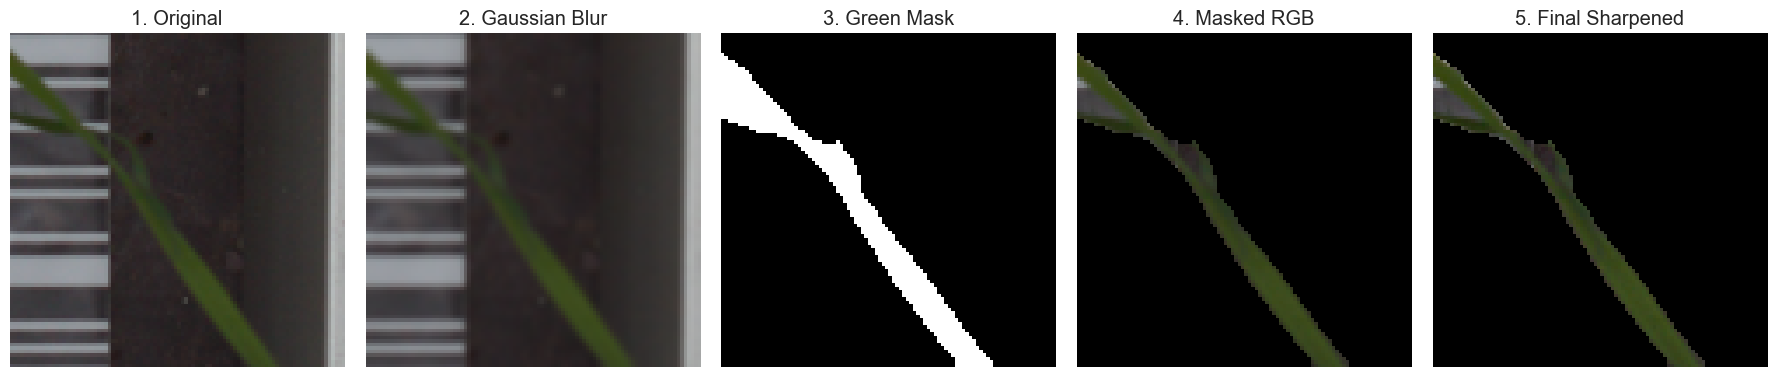

In [82]:
# --- Sharpening function using unsharp masking ---
def sharpen_image(img):
    # Apply a Gaussian blur to create a blurred version of the image
    blurred = cv2.GaussianBlur(img, (5, 5), 0)
    # Sharpening by subtracting the blurred image from the original
    sharpened = cv2.addWeighted(img, 1.5, blurred, -0.5, 0)
    return sharpened

# --- Preprocessing function ---
def preprocess_image(img_original, print_steps=False):
    """
    The input is:
    - img_original: Numpy array of shape (height, width, 3) with images in RGB format. So all images are expected
    to be in RGB format and to have the same dimensions (height x width).
    - print_steps: Boolean flag to control whether to print the preprocessing steps or not.

    Output:
    - final_img: Numpy array of shape (height, width, 3)
    """
    # --- Configuration Settings for the preprocessing ---
    lower_green = (25, 40, 50)
    upper_green = (75, 255, 255)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))

    # Converting values to uint8, because *OpenCV* functions 
    # expect images in uint8 format with 0–255 pixel intensity.
    img_uint8 = img_original.astype(np.uint8)

    Gblur_img = cv2.GaussianBlur(img_uint8, (3, 3), 0)              # 1. Gaussian blurring

    # Color Space Conversion from RGB to HSV (Hue Saturation Value):
    # HSV is better for color-based segmentation, so green colors can be isolated 
    # more easily by their hue, regardless of lighting.
    hsv_img = cv2.cvtColor(Gblur_img, cv2.COLOR_RGB2HSV)

    mask = cv2.inRange(hsv_img, lower_green, upper_green)           # 2. Green masking

    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)          # 3. Morphological filtering

    # Boolean Mask that converts the binary mask to a boolean array. Makes it easy to 
    # index into the image and apply the mask. Only pixels that are True (i.e., green areas) will be kept.
    bMask = mask > 0

    # Apply Mask, that creates a new image with only the plant parts, while everything else will be black.
    clearImg = np.zeros_like(img_uint8, np.uint8)
    clearImg[bMask] = img_uint8[bMask]

    clearImg_float = clearImg.astype(np.float32) / 255.0            # 4. Normalization of pixel values

    final_img = sharpen_image(clearImg_float)                       # 5. Sharpening of the image 

    if print_steps:
        images = [
            ("1. Original", img_uint8),
            ("2. Gaussian Blur", Gblur_img),
            ("3. Green Mask", mask),
            ("4. Masked RGB", clearImg),
            ("5. Final Sharpened", final_img)
        ]

        fig, axes = plt.subplots(1, len(images), figsize=(18, 4))
        for ax, (title, img) in zip(axes, images):
            if img.ndim == 2:
                ax.imshow(img, cmap='gray')
            else:
                ax.imshow(img)
            ax.set_title(title); ax.axis('off')
        plt.tight_layout(); plt.show()

    return final_img

# Example of a preprocessed image
adfa = preprocess_image(X[0], print_steps=True)

In [83]:
# Preprocess all the images in the dataset
X_preprocessed = []
for img in X:
    preprocess_image(img)  # Preprocess each image in the dataset
    X_preprocessed.append(preprocess_image(img))
    
X = np.array(X_preprocessed)

print("Preprocessing of the dataset complete.")

print("Saving the preprocessed dataset to the disk...")
np.savez_compressed('plant_seedlings_preprocessed.npz', images=X, labels=y)
print("Preprocessed dataset saved as 'plant_seedlings_preprocessed.npz'.")

"""
# Code for loading the preprocessed dataset
data = np.load('plant_seedlings_preprocessed.npz')
X = data['images']
y = data['labels']
"""


Preprocessing of the dataset complete.
Saving the preprocessed dataset to the disk...
Preprocessed dataset saved as 'plant_seedlings_preprocessed.npz'.


"\n# Code for loading the preprocessed dataset\ndata = np.load('plant_seedlings_preprocessed.npz')\nX = data['images']\ny = data['labels']\n"

#### Label Encoding
To prepare the input for the Neural Network we first performed the **Label Encoding**, which consists of converting the labels, associated with each sample in the dataset, into integers. Each integer is identifying a specific classification category.
Then we did the **One-hot Encoding**, which converts the class labels in *binary vectors*. This is an important operation to make sure the labels values to match with the output format of the neural network.

In [84]:
# Label encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Print the mapping of labels to integers
print("Label encoding mapping:")
for label, index in zip(label_encoder.classes_, range(len(label_encoder.classes_))):
    print(f"{label} = {index}")

y_encoded_reshaped = y_encoded.reshape(-1, 1)               # OneHotEncoder needs 2D input
onehot_encoder = OneHotEncoder(sparse_output=False)
y_one_hot = onehot_encoder.fit_transform(y_encoded_reshaped)

# Print in series 5 original, encoded, and one-hot encoded labels (randomly selected)
print("\nSample of original, encoded, and one-hot encoded labels:")
for i in random.sample(range(len(y)), 5):
    print(f"Original: {y[i]}, Encoded: {y_encoded[i]}, One-hot: {y_one_hot[i]}")

Label encoding mapping:
Black-grass = 0
Charlock = 1
Cleavers = 2
Common Chickweed = 3
Common wheat = 4
Fat Hen = 5
Loose Silky-bent = 6
Maize = 7
Scentless Mayweed = 8
Shepherds Purse = 9
Small-flowered Cranesbill = 10
Sugar beet = 11

Sample of original, encoded, and one-hot encoded labels:
Original: Black-grass, Encoded: 0, One-hot: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Original: Fat Hen, Encoded: 5, One-hot: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
Original: Loose Silky-bent, Encoded: 6, One-hot: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Original: Shepherds Purse, Encoded: 9, One-hot: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Original: Cleavers, Encoded: 2, One-hot: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


#### Dataset Splitting
The dataset was splitted with the following percentages:
- 70% Train Set
- 15% Validation Set
- 15% Test Set

The stratify option in the *train_test_split()* ensures that the class distribution is preserved in the splits. So training, validation and test set will have the same class distribution.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.18615197..0.83566946].


Data splitting completed.
X_train shape: (3325, 96, 96, 3)
y_train shape: (3325, 12)
X_val shape:   (712, 96, 96, 3)
y_val shape:   (712, 12)
X_test shape:  (713, 96, 96, 3)
y_test shape:  (713, 12)

Printing one training sample:
Image shape: (96, 96, 3), Label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


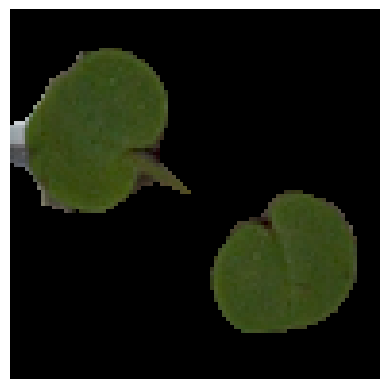

In [87]:
# First split: Train (70%) and Temp (30%)
X_train, X_temp, y_train, y_temp, y_train_enc, y_temp_enc = train_test_split(
    X, y_one_hot, y_encoded, test_size=0.30, stratify=y_encoded, random_state=42
)

# Second split: Validation (15%) and Test (15%) from Temp (30%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp_enc, random_state=42
)

print("Data splitting completed.")
print(f"X_train shape: {X_train.shape}"); print(f"y_train shape: {y_train.shape}")
print(f"X_val shape:   {X_val.shape}"); print(f"y_val shape:   {y_val.shape}")
print(f"X_test shape:  {X_test.shape}"); print(f"y_test shape:  {y_test.shape}")

print(f"\nPrinting one training sample:")
print(f"Image shape: {X_train[0].shape}, Label: {y_train[0]}")
plt.imshow(X_train[0])
plt.axis('off')
plt.show()

### Convolutional Neural Network Development

Looking for the right values of strides pools etc.

In [ ]:
def build_variant_model(
    input_shape,
    num_classes=12,
    filters=[32, 64, 128, 128],
    strides=2,
    padding='same',
    pool_type='max'  # or 'avg'
):
    model = Sequential()
    model.add(Input(shape=input_shape))

    for f in filters:
        model.add(Conv2D(f, (3, 3), activation='relu', padding=padding))
        model.add(BatchNormalization())
        if pool_type == 'max':
            model.add(MaxPooling2D(pool_size=(2, 2), strides=strides))
        else:
            model.add(AveragePooling2D(pool_size=(2, 2), strides=strides))

    model.add(Flatten())

    model.add(BatchNormalization())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))

    model.add(BatchNormalization())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))

    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(num_classes, activation='softmax'))

    return model


Training and comparing different variations

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

variants = {
    'Original': {},
    'More Filters': {'filters': [64, 128, 256, 256]},
    'Larger Stride': {'strides': 3},
    'Valid Padding': {'padding': 'valid'},
    'Average Pooling': {'pool_type': 'avg'},
}

results = {}
training_times = {}

# Make sure the base model directory exists
base_model_dir = 'models'
os.makedirs(base_model_dir, exist_ok=True)

for name, params in variants.items():
    print(f"\nTraining: {name}")
    model = build_variant_model(
        input_shape=X_train.shape[1:],
        num_classes=y_train.shape[1],
        **params
    )

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    start_time = time.time()

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=15,
        batch_size=8,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )

    end_time = time.time()
    elapsed_time = end_time - start_time

    results[name] = history.history
    training_times[name] = elapsed_time
    print(f"Training time for {name}: {elapsed_time:.2f} seconds")

    # Save the model
    safe_name = name.replace(" ", "_")  # e.g., "More Filters" -> "More_Filters"
    model_path = os.path.join(base_model_dir, safe_name)
    model.save(model_path)
    print(f"Model saved to {model_path}")



Training: Original
Epoch 1/15
416/416 [==============================] - 18s 40ms/step - loss: 2.2870 - accuracy: 0.2436 - val_loss: 4.6432 - val_accuracy: 0.0604 - lr: 0.0010
Epoch 2/15
416/416 [==============================] - 15s 36ms/step - loss: 1.7598 - accuracy: 0.3889 - val_loss: 1.4391 - val_accuracy: 0.4972 - lr: 0.0010
Epoch 3/15
416/416 [==============================] - 17s 40ms/step - loss: 1.6283 - accuracy: 0.4430 - val_loss: 1.2581 - val_accuracy: 0.5983 - lr: 0.0010
Epoch 4/15
416/416 [==============================] - 15s 35ms/step - loss: 1.5415 - accuracy: 0.4704 - val_loss: 1.3538 - val_accuracy: 0.5758 - lr: 0.0010
Epoch 5/15
415/416 [============================>.] - ETA: 0s - loss: 1.4518 - accuracy: 0.4889
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
416/416 [==============================] - 15s 36ms/step - loss: 1.4506 - accuracy: 0.4893 - val_loss: 1.4146 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 6/15
416/416 [==============

INFO:tensorflow:Assets written to: models/Original/assets


Model saved to models/Original

Training: More Filters
Epoch 1/15
416/416 [==============================] - 41s 99ms/step - loss: 2.2805 - accuracy: 0.2352 - val_loss: 5.5529 - val_accuracy: 0.0534 - lr: 0.0010
Epoch 2/15
416/416 [==============================] - 40s 97ms/step - loss: 1.8333 - accuracy: 0.3817 - val_loss: 1.6836 - val_accuracy: 0.4059 - lr: 0.0010
Epoch 3/15
416/416 [==============================] - 40s 96ms/step - loss: 1.6407 - accuracy: 0.4256 - val_loss: 1.4642 - val_accuracy: 0.5169 - lr: 0.0010
Epoch 4/15
416/416 [==============================] - 41s 98ms/step - loss: 1.5448 - accuracy: 0.4650 - val_loss: 1.1715 - val_accuracy: 0.6124 - lr: 0.0010
Epoch 5/15
416/416 [==============================] - 38s 92ms/step - loss: 1.4510 - accuracy: 0.4893 - val_loss: 1.2056 - val_accuracy: 0.5955 - lr: 0.0010
Epoch 6/15
416/416 [==============================] - ETA: 0s - loss: 1.3933 - accuracy: 0.5158
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.000500000

INFO:tensorflow:Assets written to: models/More_Filters/assets


Model saved to models/More_Filters

Training: Larger Stride
Epoch 1/15
416/416 [==============================] - 7s 17ms/step - loss: 2.3252 - accuracy: 0.2430 - val_loss: 2.8950 - val_accuracy: 0.1910 - lr: 0.0010
Epoch 2/15
416/416 [==============================] - 7s 16ms/step - loss: 1.8600 - accuracy: 0.3540 - val_loss: 1.4567 - val_accuracy: 0.5183 - lr: 0.0010
Epoch 3/15
416/416 [==============================] - 7s 17ms/step - loss: 1.6407 - accuracy: 0.4337 - val_loss: 2.2898 - val_accuracy: 0.3652 - lr: 0.0010
Epoch 4/15
416/416 [==============================] - 7s 18ms/step - loss: 1.5140 - accuracy: 0.4731 - val_loss: 1.4329 - val_accuracy: 0.5253 - lr: 0.0010
Epoch 5/15
416/416 [==============================] - 8s 20ms/step - loss: 1.4156 - accuracy: 0.5047 - val_loss: 2.6528 - val_accuracy: 0.3567 - lr: 0.0010
Epoch 6/15
416/416 [==============================] - 7s 17ms/step - loss: 1.3375 - accuracy: 0.5420 - val_loss: 1.0725 - val_accuracy: 0.6334 - lr: 0.0010
Epoc

INFO:tensorflow:Assets written to: models/Larger_Stride/assets


Model saved to models/Larger_Stride

Training: Valid Padding
Epoch 1/15
416/416 [==============================] - 12s 27ms/step - loss: 2.2041 - accuracy: 0.2725 - val_loss: 4.3111 - val_accuracy: 0.1461 - lr: 0.0010
Epoch 2/15
416/416 [==============================] - 12s 28ms/step - loss: 1.7764 - accuracy: 0.3877 - val_loss: 1.3641 - val_accuracy: 0.5126 - lr: 0.0010
Epoch 3/15
416/416 [==============================] - 11s 27ms/step - loss: 1.6131 - accuracy: 0.4424 - val_loss: 2.3774 - val_accuracy: 0.3708 - lr: 0.0010
Epoch 4/15
416/416 [==============================] - 11s 25ms/step - loss: 1.5241 - accuracy: 0.4677 - val_loss: 1.2114 - val_accuracy: 0.5787 - lr: 0.0010
Epoch 5/15
416/416 [==============================] - 11s 26ms/step - loss: 1.3784 - accuracy: 0.5107 - val_loss: 1.2092 - val_accuracy: 0.5562 - lr: 0.0010
Epoch 6/15
416/416 [==============================] - 12s 28ms/step - loss: 1.3187 - accuracy: 0.5414 - val_loss: 1.0039 - val_accuracy: 0.6629 - lr: 0.00

INFO:tensorflow:Assets written to: models/Valid_Padding/assets


Model saved to models/Valid_Padding

Training: Average Pooling
Epoch 1/15
416/416 [==============================] - 14s 32ms/step - loss: 2.1749 - accuracy: 0.2782 - val_loss: 5.9018 - val_accuracy: 0.0604 - lr: 0.0010
Epoch 2/15
416/416 [==============================] - 13s 31ms/step - loss: 1.7590 - accuracy: 0.3994 - val_loss: 2.0076 - val_accuracy: 0.3315 - lr: 0.0010
Epoch 3/15
416/416 [==============================] - 13s 31ms/step - loss: 1.6124 - accuracy: 0.4409 - val_loss: 3.3295 - val_accuracy: 0.3160 - lr: 0.0010
Epoch 4/15
415/416 [============================>.] - ETA: 0s - loss: 1.5075 - accuracy: 0.4807
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
416/416 [==============================] - 13s 31ms/step - loss: 1.5091 - accuracy: 0.4803 - val_loss: 11.3132 - val_accuracy: 0.1868 - lr: 0.0010
Epoch 5/15
416/416 [==============================] - 13s 31ms/step - loss: 1.3745 - accuracy: 0.5278 - val_loss: 1.0409 - val_accuracy: 0.6292 - l

INFO:tensorflow:Assets written to: models/Average_Pooling/assets


Model saved to models/Average_Pooling


Plotting and analysing

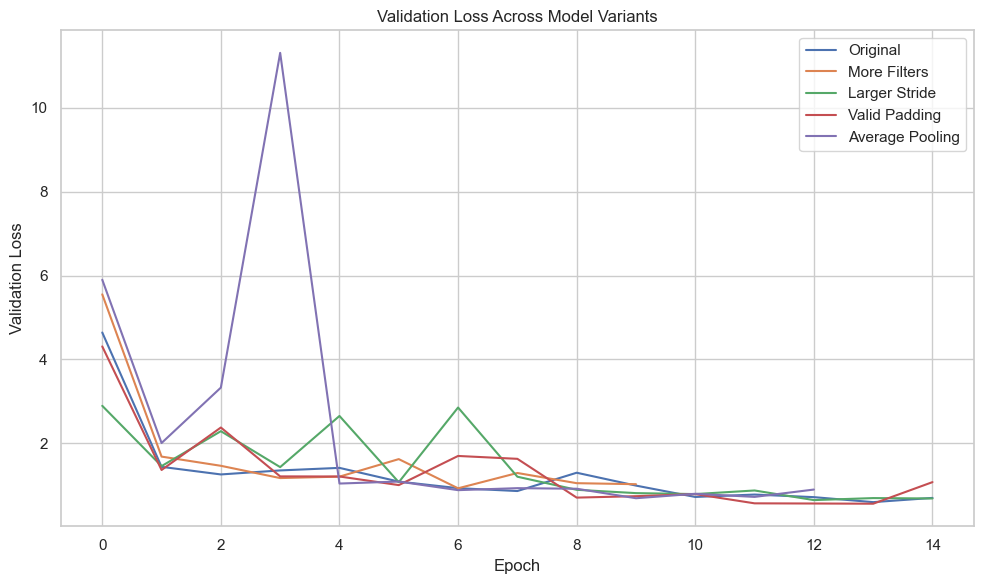

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for name, history in results.items():
    val_loss = history.get('val_loss')
    if val_loss:  # Make sure it exists
        plt.plot(val_loss, label=name)

plt.title('Validation Loss Across Model Variants')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Change	Possible Impact
More filters	May improve accuracy but increase computation.
Larger strides	Reduces spatial resolution faster — may lose detail.
Valid padding	Shrinks feature maps — can lose edge info.
Average pooling	May retain smoother features vs. max-pooling (sharper features).

## Build of probably good model


In [ ]:
ins = X_train.shape[1:]

# Modified Best Model (adjustments to prevent overfitting and increase depth)
def build_no_callbacks_model(input_shape=(ins[0], ins[1], ins[2]), num_classes=12):
    model = Sequential()

    # 1st Convolutional Block
    model.add(Input(shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

    # 2nd Convolutional Block
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

    # 3rd Convolutional Block
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

    # 4th Convolutional Block (additional block to add more depth)
    model.add(Conv2D(128, (3, 3), activation='relu', padding='valid'))  # No padding
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

    # Flatten before Dense layers
    model.add(Flatten())

    # Fully Connected Layers
    model.add(BatchNormalization())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))  # Increased dropout to 0.3 for more regularization

    model.add(BatchNormalization())
    model.add(Dense(256, activation='relu'))  # Increased units in dense layer
    model.add(Dropout(0.3))  # Dropout to avoid overfitting

    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))  # Dropout at the final dense layer

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))

    return model


## Running the probable model but without callbacks


In [ ]:
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

model = build_no_callbacks_model()

from tensorflow.keras.metrics import Precision, Recall

model.compile(
    optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

history1 = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=8
)


Epoch 1/30
416/416 [==============================] - 13s 31ms/step - loss: 2.1599 - accuracy: 0.2938 - precision_2: 0.4576 - recall_2: 0.1299 - val_loss: 7.0940 - val_accuracy: 0.0604 - val_precision_2: 0.0604 - val_recall_2: 0.0604
Epoch 2/30
416/416 [==============================] - 13s 30ms/step - loss: 1.7520 - accuracy: 0.3979 - precision_2: 0.5398 - recall_2: 0.2265 - val_loss: 1.4674 - val_accuracy: 0.4972 - val_precision_2: 0.6404 - val_recall_2: 0.2626
Epoch 3/30
416/416 [==============================] - 13s 30ms/step - loss: 1.6352 - accuracy: 0.4340 - precision_2: 0.6020 - recall_2: 0.2689 - val_loss: 1.4389 - val_accuracy: 0.5070 - val_precision_2: 0.6525 - val_recall_2: 0.4087
Epoch 4/30
416/416 [==============================] - 13s 30ms/step - loss: 1.5010 - accuracy: 0.4770 - precision_2: 0.6145 - recall_2: 0.2914 - val_loss: 1.1779 - val_accuracy: 0.5927 - val_precision_2: 0.7559 - val_recall_2: 0.4480
Epoch 5/30
416/416 [==============================] - 13s 30ms/s

## Illustration of convolution results of a specific Layer[1,2,3]no 1 is specified now it the code, visualisation of feature maps

In [58]:
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.output_shape)

0 conv2d_36 (None, 96, 96, 32)
1 batch_normalization_63 (None, 96, 96, 32)
2 max_pooling2d_32 (None, 48, 48, 32)
3 conv2d_37 (None, 48, 48, 64)
4 batch_normalization_64 (None, 48, 48, 64)
5 max_pooling2d_33 (None, 24, 24, 64)
6 conv2d_38 (None, 24, 24, 128)
7 batch_normalization_65 (None, 24, 24, 128)
8 max_pooling2d_34 (None, 12, 12, 128)
9 conv2d_39 (None, 10, 10, 128)
10 batch_normalization_66 (None, 10, 10, 128)
11 max_pooling2d_35 (None, 5, 5, 128)
12 flatten_9 (None, 3200)
13 batch_normalization_67 (None, 3200)
14 dense_36 (None, 512)
15 dropout_27 (None, 512)
16 batch_normalization_68 (None, 512)
17 dense_37 (None, 256)
18 dropout_28 (None, 256)
19 batch_normalization_69 (None, 256)
20 dense_38 (None, 128)
21 dropout_29 (None, 128)
22 dense_39 (None, 12)


1/1 [==============================] - 0s 63ms/step


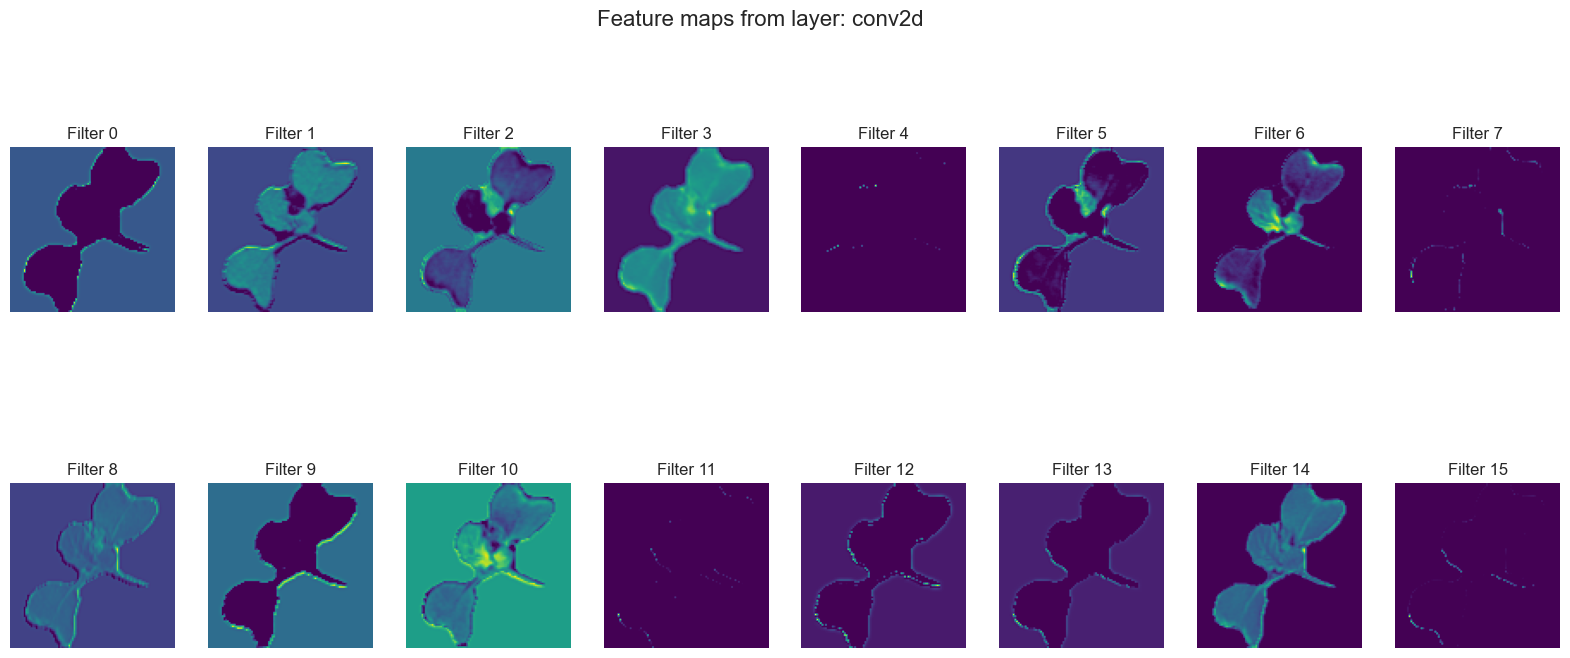

In [ ]:

import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import numpy as np


# Pick a sample image (reshape if needed)
sample_image = X_val[0]  # shape: (H, W, C)
sample_image = np.expand_dims(sample_image, axis=0)  # add batch dimension

# Pick a layer to visualize (e.g., 'conv2d' or layer index)
layer_name = 'conv2d'  # or model.layers[1].name
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[1].output)

# Get feature maps
feature_maps = intermediate_layer_model.predict(sample_image)

# Plot the feature maps
num_filters = feature_maps.shape[-1]
size = feature_maps.shape[1]

plt.figure(figsize=(20, 8))
for i in range(min(num_filters, 16)):  # Show first 16 filters
    ax = plt.subplot(2, 8, i + 1)
    plt.imshow(feature_maps[0, :, :, i], cmap='viridis')
    plt.axis('off')
    plt.title(f'Filter {i}')
plt.suptitle(f"Feature maps from layer: {layer_name}", fontsize=16)
plt.show()


Insights:

## Accuracy of the probable model without callbacks

In [ ]:
results = model.evaluate(X_test, y_test)

23/23 [==============================] - 1s 27ms/step - loss: 0.7355 - accuracy: 0.7966 - precision_1: 0.8349 - recall_1: 0.7588


23/23 [==============================] - 1s 29ms/step

--- Classification Report ---
                           precision    recall  f1-score   support

              Black-grass       0.52      0.28      0.37        39
                 Charlock       0.94      0.57      0.71        58
                 Cleavers       0.93      0.65      0.77        43
         Common Chickweed       0.81      0.82      0.81        92
             Common wheat       0.63      0.82      0.71        33
                  Fat Hen       0.70      0.97      0.81        72
         Loose Silky-bent       0.74      0.91      0.82        98
                    Maize       0.88      0.70      0.78        33
        Scentless Mayweed       0.75      0.59      0.66        78
          Shepherds Purse       0.43      0.62      0.51        34
Small-flowered Cranesbill       0.80      0.96      0.87        75
               Sugar beet       0.93      0.72      0.82        58

                 accuracy                 

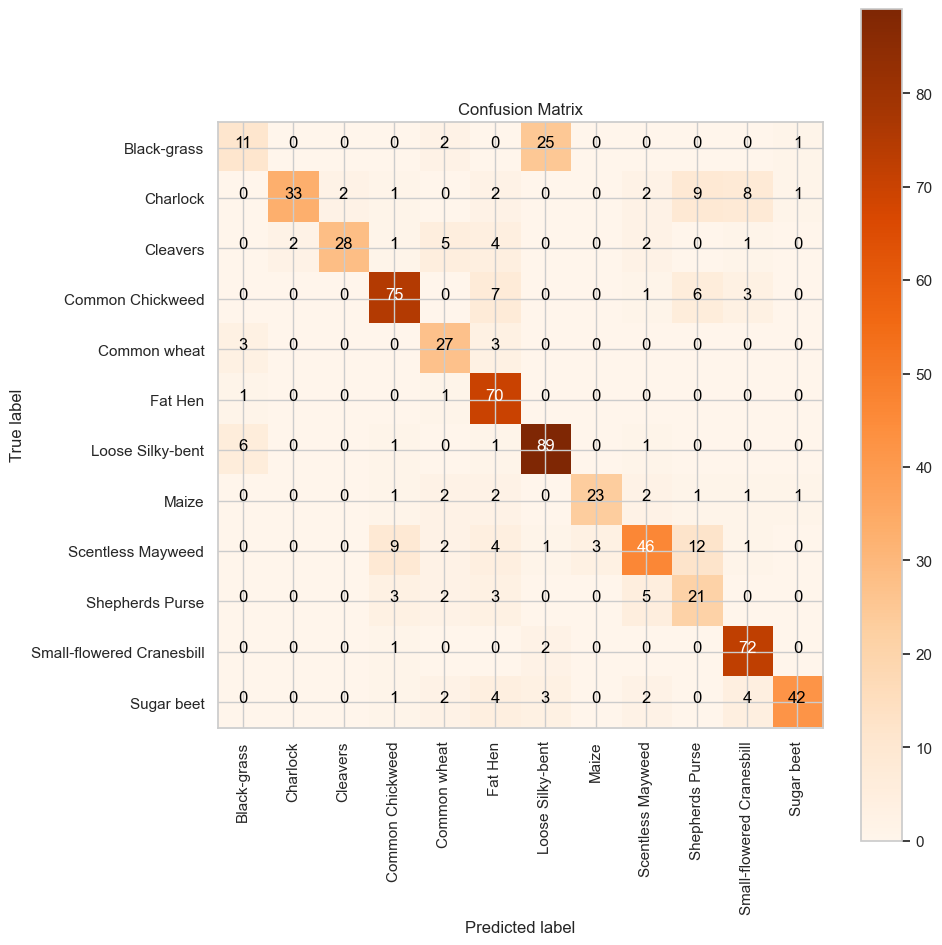

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import itertools

# --- Funkcja rysująca confusion matrix ---
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):  # Change the colormap here
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f'{cm[i, j]:.2f}' if normalize else f'{cm[i, j]}',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# --- Predykcje modelu na testowym zbiorze ---
predY = model.predict(X_test)
predYClasses = np.argmax(predY, axis=1)  # Predicted classes (0-based index)
trueY = np.argmax(y_test, axis=1)        # True labels (0-based index)

# --- Macierz pomyłek (Confusion Matrix) ---
confusionMTX = confusion_matrix(trueY, predYClasses)

# --- Reverse the label-to-index mapping ---
# If label_to_index maps {class_name: index}, reverse it to {index: class_name}
index_to_label = {v: k for k, v in label_to_index.items()}

# --- Get class names for plotting ---
categ = [index_to_label[i] for i in range(len(index_to_label))]

# --- Rysowanie confusion matrix ---
plot_confusion_matrix(confusionMTX, classes=categ, normalize=False, cmap=plt.cm.Oranges)

# --- Classification report ---
print("\n--- Classification Report ---")
print(classification_report(trueY, predYClasses, target_names=categ))


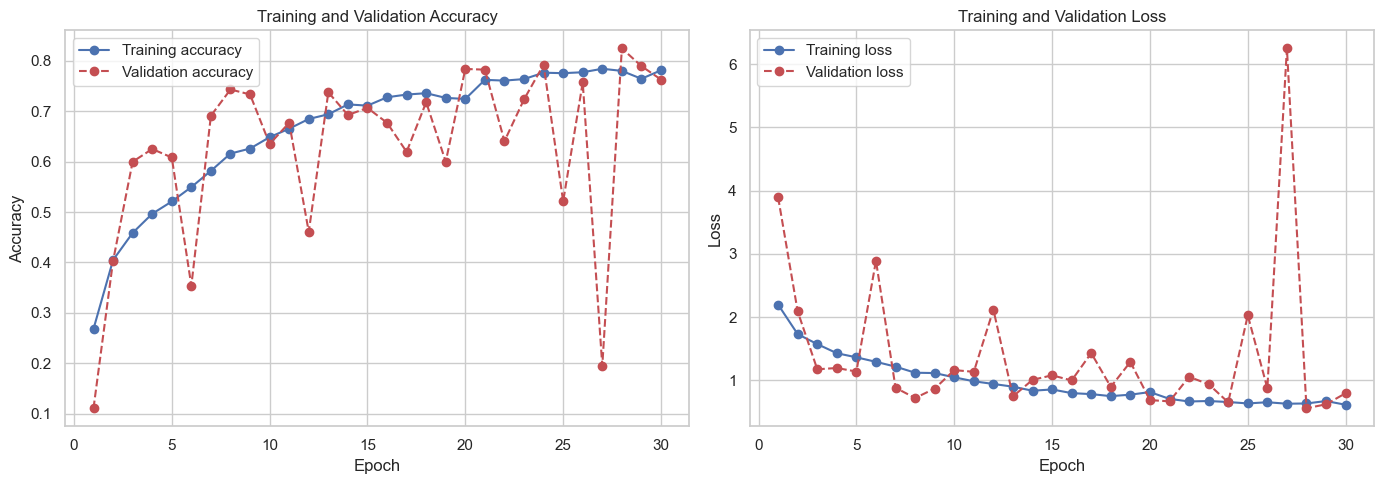

In [63]:
import matplotlib.pyplot as plt

def plot_accuracy_and_loss(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'ro--', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro--', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_accuracy_and_loss(history1)

There is definately some overfitting because:
We will now introduce such us Early Stopping and

## Running the model with callbacks

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Define callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

model = build_no_callbacks_model()

from tensorflow.keras.metrics import Precision, Recall

model.compile(
    optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

history2 = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=8,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/50
416/416 [==============================] - 14s 32ms/step - loss: 2.2947 - accuracy: 0.2439 - precision_3: 0.4017 - recall_3: 0.0842 - val_loss: 4.8314 - val_accuracy: 0.0829 - val_precision_3: 0.1028 - val_recall_3: 0.0829 - lr: 0.0010
Epoch 2/50
416/416 [==============================] - 14s 33ms/step - loss: 1.8646 - accuracy: 0.3492 - precision_3: 0.5248 - recall_3: 0.1717 - val_loss: 2.3300 - val_accuracy: 0.2416 - val_precision_3: 0.2952 - val_recall_3: 0.1559 - lr: 0.0010
Epoch 3/50
416/416 [==============================] - 13s 31ms/step - loss: 1.5928 - accuracy: 0.4535 - precision_3: 0.5964 - recall_3: 0.2698 - val_loss: 1.2176 - val_accuracy: 0.5899 - val_precision_3: 0.6989 - val_recall_3: 0.4466 - lr: 0.0010
Epoch 4/50
416/416 [==============================] - 14s 33ms/step - loss: 1.4824 - accuracy: 0.4854 - precision_3: 0.6153 - recall_3: 0.3002 - val_loss: 1.1927 - val_accuracy: 0.5885 - val_precision_3: 0.7383 - val_recall_3: 0.4199 - lr: 0.0010
Epoch 5/50
4

 Interpretation:

✅ High precision and recall on validation data suggests the model is generalizing well and not overfitting.

✅ Validation accuracy > training accuracy can mean regularization (e.g., dropout, early stopping) helped prevent overfitting.

✅ Low validation loss confirms the model is confident and consistent in its predictions.

📉 Early Stopping
The message Restoring model weights from the end of the best epoch: 29 confirms that early stopping restored the best weights, avoiding any overfitting in the final epoch.
We then increased the number of Epochs to 50 so that we can better observe the Early Stopping callback behaviour. The program this time restorted weights at 35th epoch. While at the same time we increased patience the acuracy increased from 0.85-0.88

## Evaluation of accuracy

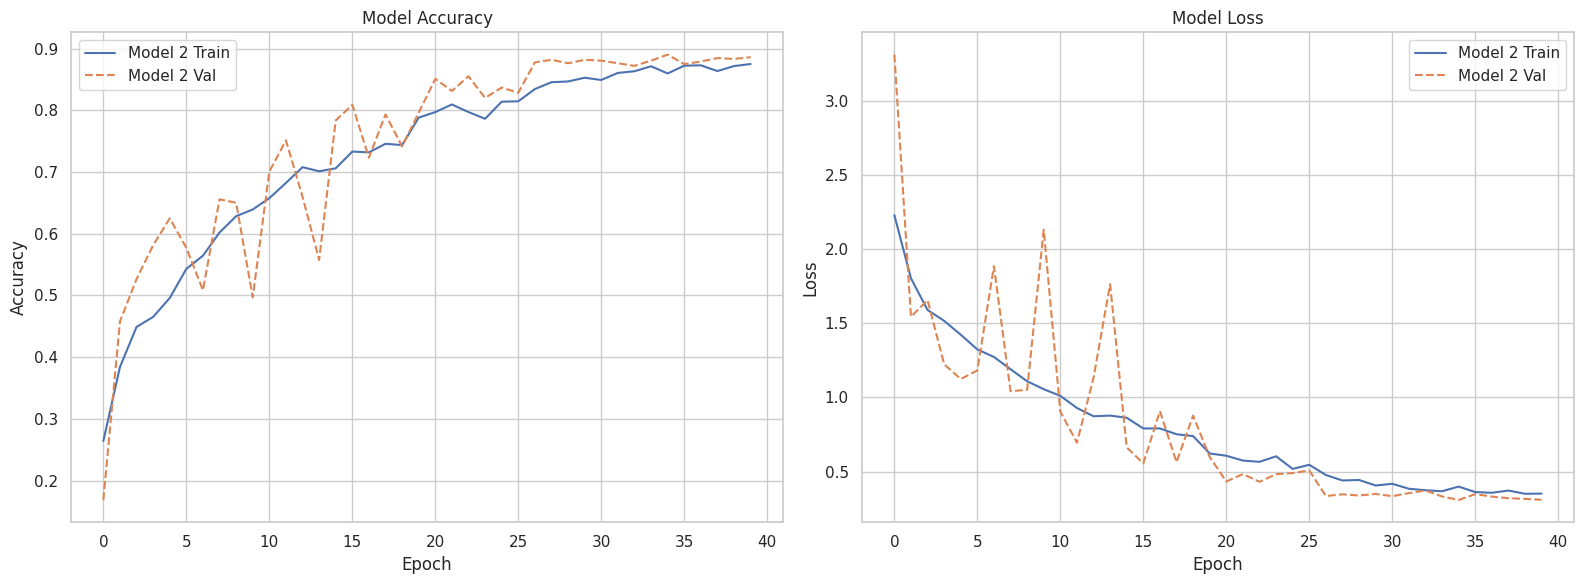

In [ ]:
import matplotlib.pyplot as plt

# Function to extract metrics for plotting
def extract_metrics(history):
    return (
        history.history['accuracy'],
        history.history['val_accuracy'],
        history.history['loss'],
        history.history['val_loss'],
    )

# Assuming these are available in your session already
histories = {
    #"Model 1": history1.history if 'history1' in globals() else None,
    "Model 2": history2.history if 'history2' in globals() else None
}

# Plotting
plt.figure(figsize=(16, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
for name, h in histories.items():
    if h:  # Check if history is available
        plt.plot(h['accuracy'], label=f'{name} Train')
        plt.plot(h['val_accuracy'], linestyle='--', label=f'{name} Val')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)


In [ ]:
results = model.evaluate(X_test, y_test)

23/23 [==============================] - 1s 26ms/step - loss: 0.3907 - accuracy: 0.8850 - precision_3: 0.8948 - recall_3: 0.8710


23/23 [==============================] - 1s 29ms/step

--- Classification Report ---
                           precision    recall  f1-score   support

              Black-grass       0.67      0.10      0.18        39
                 Charlock       0.98      0.93      0.96        58
                 Cleavers       0.93      0.95      0.94        43
         Common Chickweed       0.93      0.98      0.95        92
             Common wheat       0.76      0.94      0.84        33
                  Fat Hen       0.97      0.96      0.97        72
         Loose Silky-bent       0.75      0.96      0.84        98
                    Maize       0.81      0.91      0.86        33
        Scentless Mayweed       0.91      0.90      0.90        78
          Shepherds Purse       0.77      0.71      0.74        34
Small-flowered Cranesbill       0.99      0.96      0.97        75
               Sugar beet       0.93      0.90      0.91        58

                 accuracy                 

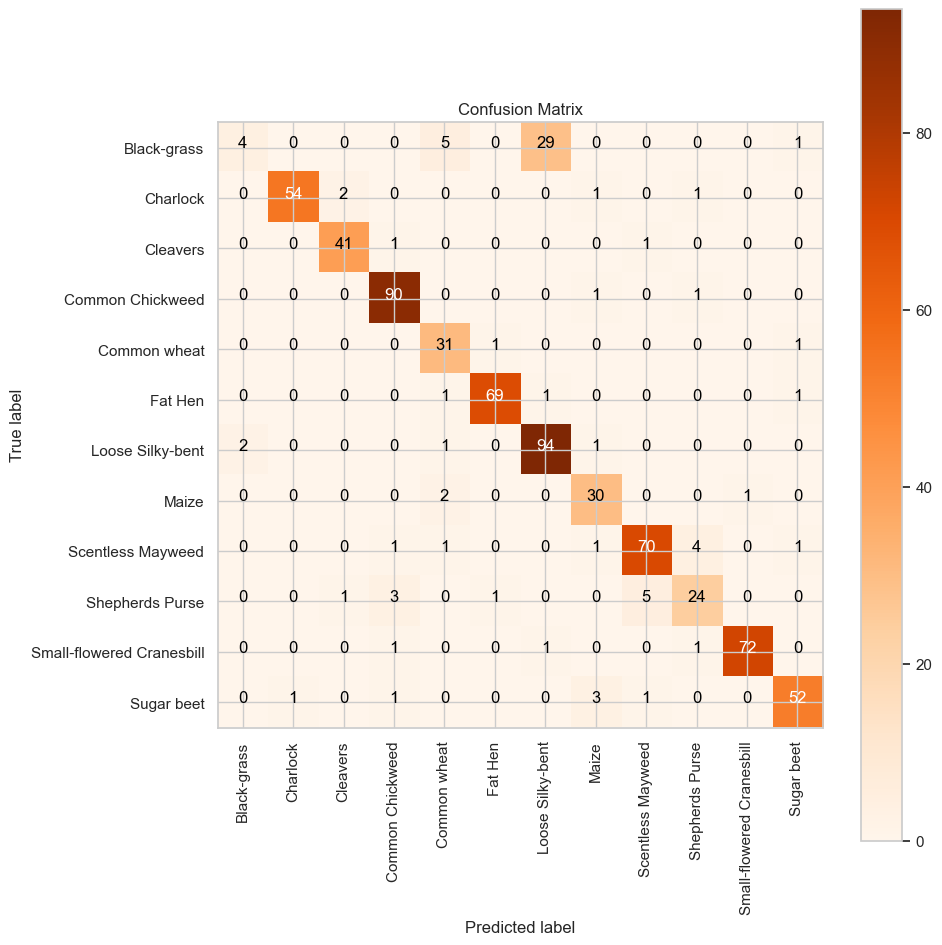

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import itertools

# --- Funkcja rysująca confusion matrix ---
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):  # Change the colormap here
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f'{cm[i, j]:.2f}' if normalize else f'{cm[i, j]}',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# --- Predykcje modelu na testowym zbiorze ---
predY = model.predict(X_test)
predYClasses = np.argmax(predY, axis=1)  # Predicted classes (0-based index)
trueY = np.argmax(y_test, axis=1)        # True labels (0-based index)

# --- Macierz pomyłek (Confusion Matrix) ---
confusionMTX = confusion_matrix(trueY, predYClasses)

# --- Reverse the label-to-index mapping ---
# If label_to_index maps {class_name: index}, reverse it to {index: class_name}
index_to_label = {v: k for k, v in label_to_index.items()}

# --- Get class names for plotting ---
categ = [index_to_label[i] for i in range(len(index_to_label))]

# --- Rysowanie confusion matrix ---
plot_confusion_matrix(confusionMTX, classes=categ, normalize=False, cmap=plt.cm.Oranges)

# --- Classification report ---
print("\n--- Classification Report ---")
print(classification_report(trueY, predYClasses, target_names=categ))


In [ ]:
results = model.evaluate(X_test, y_test)

23/23 [==============================] - 1s 27ms/step - loss: 0.3907 - accuracy: 0.8850 - precision_3: 0.8948 - recall_3: 0.8710


## Adding data-augmentation and running models with it

here I will implement model with data augmentation

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Data Augmentation for training set only
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the generator to your data (optional, depending on data type)
datagen.fit(X_train)

# Create the model
model = build_no_callbacks_model()

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
    loss='categorical_crossentropy',
    metrics = ['accuracy', Precision(), Recall()]
)

# Train the model using the augmented data
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=8),
    validation_data=(X_val, y_val),
    epochs=50,
    callbacks=[early_stop, reduce_lr],
    steps_per_epoch=len(X_train) // 8
)


Epoch 1/50
415/415 [==============================] - 14s 33ms/step - loss: 2.2816 - accuracy: 0.2418 - precision_1: 0.4114 - recall_1: 0.0889 - val_loss: 2.5630 - val_accuracy: 0.2093 - val_precision_1: 0.2000 - val_recall_1: 0.0843 - lr: 0.0010
Epoch 2/50
415/415 [==============================] - 13s 32ms/step - loss: 1.8676 - accuracy: 0.3729 - precision_1: 0.5009 - recall_1: 0.1682 - val_loss: 3.0607 - val_accuracy: 0.3315 - val_precision_1: 0.3814 - val_recall_1: 0.3118 - lr: 0.0010
Epoch 3/50
415/415 [==============================] - 13s 31ms/step - loss: 1.7039 - accuracy: 0.4121 - precision_1: 0.5609 - recall_1: 0.2195 - val_loss: 1.9721 - val_accuracy: 0.4565 - val_precision_1: 0.5347 - val_recall_1: 0.3792 - lr: 0.0010
Epoch 4/50
415/415 [==============================] - 13s 31ms/step - loss: 1.5729 - accuracy: 0.4549 - precision_1: 0.6176 - recall_1: 0.2581 - val_loss: 1.2445 - val_accuracy: 0.5857 - val_precision_1: 0.6736 - val_recall_1: 0.5014 - lr: 0.0010
Epoch 5/50
4

23/23 [==============================] - 1s 29ms/step
Confusion matrix, without normalization


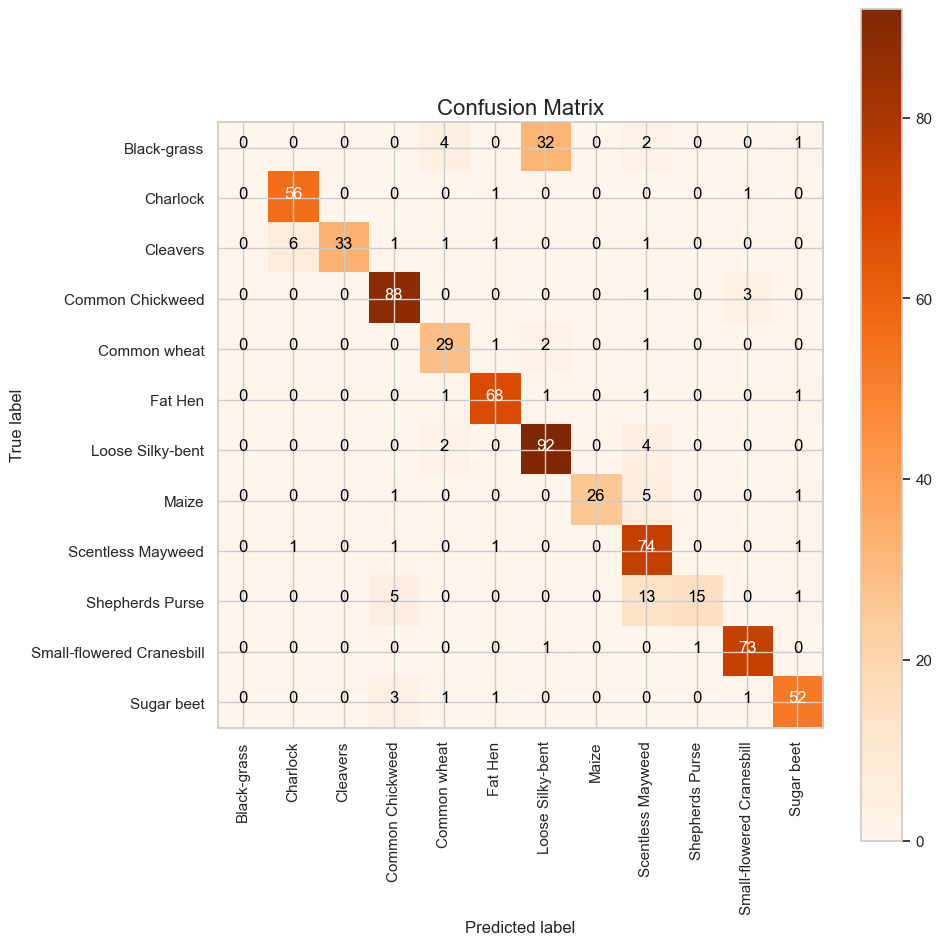


Classification Report:

                           precision    recall  f1-score   support

              Black-grass       0.00      0.00      0.00        39
                 Charlock       0.89      0.97      0.93        58
                 Cleavers       1.00      0.77      0.87        43
         Common Chickweed       0.89      0.96      0.92        92
             Common wheat       0.76      0.88      0.82        33
                  Fat Hen       0.93      0.94      0.94        72
         Loose Silky-bent       0.72      0.94      0.81        98
                    Maize       1.00      0.79      0.88        33
        Scentless Mayweed       0.73      0.95      0.82        78
          Shepherds Purse       0.94      0.44      0.60        34
Small-flowered Cranesbill       0.94      0.97      0.95        75
               Sugar beet       0.91      0.90      0.90        58

                 accuracy                           0.85       713
                macro avg       0.8

/Users/filiporlikowski/Documents/APROF/CNN/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/filiporlikowski/Documents/APROF/CNN/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/filiporlikowski/Documents/APROF/CNN/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import itertools

# --- Predict the classes on test set ---
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# --- Create confusion matrix ---
conf_matrix = confusion_matrix(y_true, y_pred)

# --- Create label index mapping (reverse) ---
index_to_label = {v: k for k, v in label_to_index.items()}
class_names = [index_to_label[i] for i in range(len(index_to_label))]

# --- Plot confusion matrix ---
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        value = f"{cm[i, j]:.2f}" if normalize else f"{cm[i, j]}"
        plt.text(j, i, value,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.tight_layout()
    plt.show()

# --- Show confusion matrix ---
plot_confusion_matrix(conf_matrix, classes=class_names, normalize=False, cmap=plt.cm.Oranges)

# --- Optional: Classification report ---
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


## Running the pretrained Resnet50 model

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define input shape
input_shape = X_train.shape[1:]  # (height, width, channels)
num_classes = 12  # change as needed

# Load ResNet50 base model without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))

# Freeze base model layers to prevent training initially
base_model.trainable = False

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

# Create final model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Train the model
history_resnet = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=8,
    callbacks=[early_stop, reduce_lr]
)


94765736/94765736 [==============================] - 8s 0us/step


Epoch 1/30
416/416 [==============================] - 23s 53ms/step - loss: 2.4887 - accuracy: 0.1242 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - val_loss: 2.4084 - val_accuracy: 0.1067 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - lr: 0.0010
Epoch 2/30
416/416 [==============================] - 22s 53ms/step - loss: 2.4127 - accuracy: 0.1600 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - val_loss: 2.3756 - val_accuracy: 0.2121 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - lr: 0.0010
Epoch 3/30
416/416 [==============================] - 22s 54ms/step - loss: 2.3777 - accuracy: 0.1633 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00 - val_loss: 2.3234 - val_accuracy: 0.1784 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - lr: 0.0010
Epoch 4/30
416/416 [==============================] - 22s 53ms/step - loss: 2.3516 - accuracy: 0.1832 - precision_4: 0.5333 - recall_4: 0.0024 - val_loss: 2.3088 - val_accuracy: 0.2037 - val_precision_4: 0.0000e

In [ ]:
results = model.evaluate(X_test, y_test)

23/23 [==============================] - 4s 137ms/step - loss: 2.0499 - accuracy: 0.2805 - precision_4: 0.4545 - recall_4: 0.0070


## Results of pretrained model

23/23 [==============================] - 4s 139ms/step


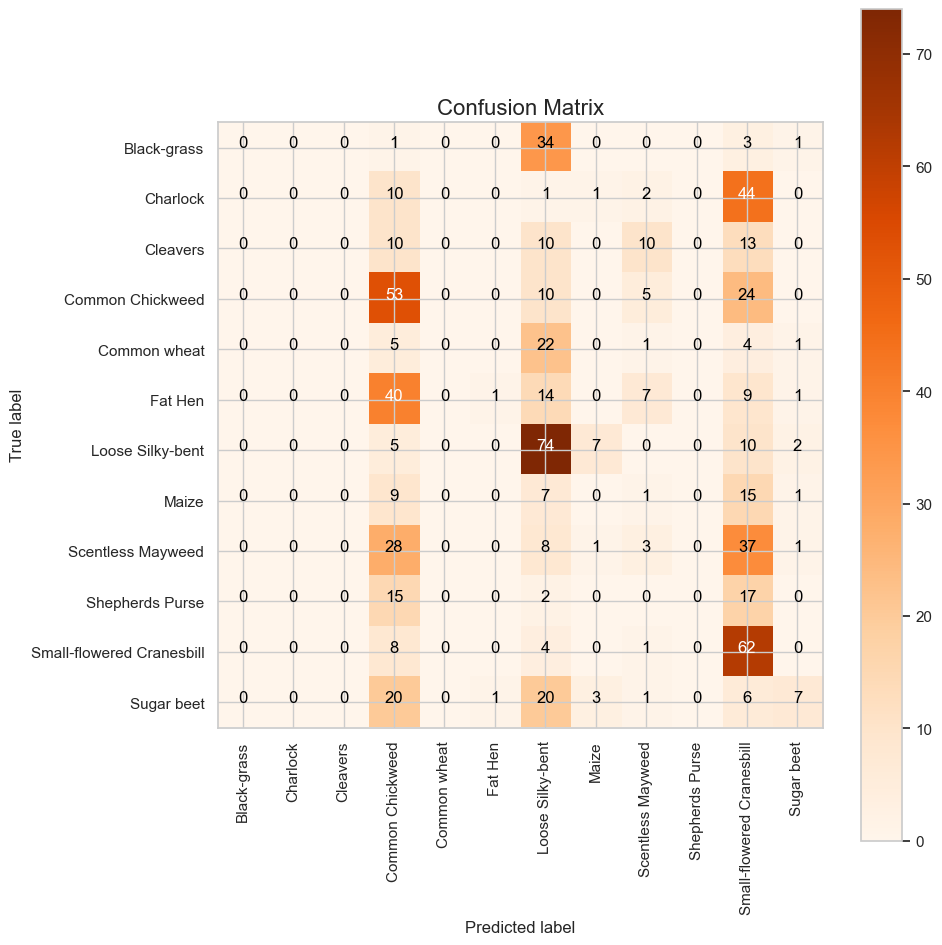


--- Classification Report ---
                           precision    recall  f1-score   support

              Black-grass       0.00      0.00      0.00        39
                 Charlock       0.00      0.00      0.00        58
                 Cleavers       0.00      0.00      0.00        43
         Common Chickweed       0.26      0.58      0.36        92
             Common wheat       0.00      0.00      0.00        33
                  Fat Hen       0.50      0.01      0.03        72
         Loose Silky-bent       0.36      0.76      0.49        98
                    Maize       0.00      0.00      0.00        33
        Scentless Mayweed       0.10      0.04      0.06        78
          Shepherds Purse       0.00      0.00      0.00        34
Small-flowered Cranesbill       0.25      0.83      0.39        75
               Sugar beet       0.50      0.12      0.19        58

                 accuracy                           0.28       713
                macro avg    

/Users/filiporlikowski/Documents/APROF/CNN/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/filiporlikowski/Documents/APROF/CNN/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/filiporlikowski/Documents/APROF/CNN/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import itertools

# --- Predict on test set ---
predY = model.predict(X_test)
predYClasses = np.argmax(predY, axis=1)      # predicted class indices
trueY = np.argmax(y_test, axis=1)            # true class indices

# --- Confusion Matrix ---
confusionMTX = confusion_matrix(trueY, predYClasses)

# --- Label mapping ---
index_to_label = {v: k for k, v in label_to_index.items()}
class_names = [index_to_label[i] for i in range(len(index_to_label))]

# --- Plot Confusion Matrix ---
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Oranges):  # You can change the color map here
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        val = f'{cm[i, j]:.2f}' if normalize else f'{cm[i, j]}'
        plt.text(j, i, val, horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# --- Show confusion matrix ---
plot_confusion_matrix(confusionMTX, classes=class_names, normalize=False)

# --- Show classification report ---
print("\n--- Classification Report ---")
print(classification_report(trueY, predYClasses, target_names=class_names))


In [ ]:
# --- Plot training & validation loss ---
plt.figure(figsize=(8, 6))
plt.plot(history_resnet.history['loss'], label='Training Loss')
plt.plot(history_resnet.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Fixes Applied:
Proper ResNet50 preprocessing
Partial fine-tuning (unfreezing top layers)
Model rebuilt with dropout and dense layers
Training with EarlyStopping and ReduceLROnPlateau
Data augmentation included
Classification report + confusion matrix after training

What was wrong: The application of proper input preprocessing is critical when using pretrained models like ResNet50 because these models were trained on the ImageNet dataset under very specific conditions. In your original pipeline, images were normalized to have pixel values in the range [0, 1], maintained in RGB channel order, and had no mean subtraction applied. While this format is common and perfectly valid for training models from scratch, it does not align with what ResNet50 was originally trained on. ResNet50 expects images to have pixel values in the range [0, 255], be in BGR channel order (as used by OpenCV), and have specific mean pixel values subtracted from each channel: 103.939 for Blue, 116.779 for Green, and 123.68 for Red. These preprocessing steps are crucial because they shape the way the model interprets color, contrast, and features. Feeding the model incorrectly scaled and ordered data leads to a mismatch between the features the model expects to see and the actual input, causing the convolutional filters—learned on differently preprocessed data—to activate incorrectly or not at all. As a result, performance suffers, often severely. By applying the correct preprocessing function (preprocess_input from keras.applications.resnet50), we ensure the input is transformed to match the conditions of the original ImageNet training. This allows ResNet50 to fully leverage its pretrained filters, resulting in significantly improved feature extraction and classification accuracy. Proper preprocessing bridges the gap between your dataset and the pretrained model, making transfer learning both viable and effective.

Your Original Input Format
Your images were:

Resized to 224x224x3
Normalized to float32 values in the range [0, 1] (via img.astype(np.float32) / 255.0)
In RGB color order (standard in most image preprocessing pipelines)
This format is commonly used when training models from scratch or with custom architectures.

⚠️ Why That’s a Problem for ResNet50
ResNet50, when loaded with weights='imagenet', was pretrained using the ImageNet dataset, which follows a very specific preprocessing scheme:

Requirement	Your Format	ResNet50 Expectation
Data Type	float32	float32
Pixel Range	[0, 1]	[0, 255] (uint8-like)
Mean Subtraction	❌ Not applied	✅ Subtracts [103.939, 116.779, 123.68] from BGR channels
Channel Order	RGB	BGR (like OpenCV format)
So even though your image shapes and types were valid, the pixel values and color interpretation were wrong for ResNet50. This misalignment caused the model to misinterpret image content, drastically hurting performance.

✅ What preprocess_input Does (for resnet50)
The preprocess_input function in keras.applications.resnet50 performs:

Converts RGB → BGR (reordering channels)
Scales from [0, 255] to ImageNet format
Subtracts ImageNet mean pixel values:
[103.939, 116.779, 123.68] for Blue, Green, Red channels respectively
In short, preprocess_input mimics the exact preprocessing ResNet50 used during training, which is crucial for transfer learning to work effectively.

🧠 Summary
Without proper preprocessing:

You fed ResNet50 data it wasn't trained to understand.
It saw color distributions and pixel intensities that didn’t match ImageNet, confusing the learned filters.
Result: poor feature extraction → poor performance.
After applying the correct preprocessing, the model receives input in a familiar format, allowing it to reuse its pretrained knowledge effectively.

Epoch 1/30
415/415 [==============================] - 39s 91ms/step - loss: 1.3485 - accuracy: 0.5592 - precision_5: 0.6701 - recall_5: 0.4293 - val_loss: 0.9144 - val_accuracy: 0.7275 - val_precision_5: 0.7748 - val_recall_5: 0.7008 - lr: 5.0000e-04
Epoch 2/30
415/415 [==============================] - 36s 87ms/step - loss: 0.8657 - accuracy: 0.6970 - precision_5: 0.7707 - recall_5: 0.6120 - val_loss: 0.5341 - val_accuracy: 0.8272 - val_precision_5: 0.8629 - val_recall_5: 0.7781 - lr: 5.0000e-04
Epoch 3/30
415/415 [==============================] - 38s 91ms/step - loss: 0.6406 - accuracy: 0.7754 - precision_5: 0.8245 - recall_5: 0.7154 - val_loss: 0.6053 - val_accuracy: 0.8104 - val_precision_5: 0.8311 - val_recall_5: 0.7809 - lr: 5.0000e-04
Epoch 4/30
415/415 [==============================] - 38s 91ms/step - loss: 0.5830 - accuracy: 0.7938 - precision_5: 0.8374 - recall_5: 0.7516 - val_loss: 0.6514 - val_accuracy: 0.8006 - val_precision_5: 0.8306 - val_recall_5: 0.7711 - lr: 5.0000e

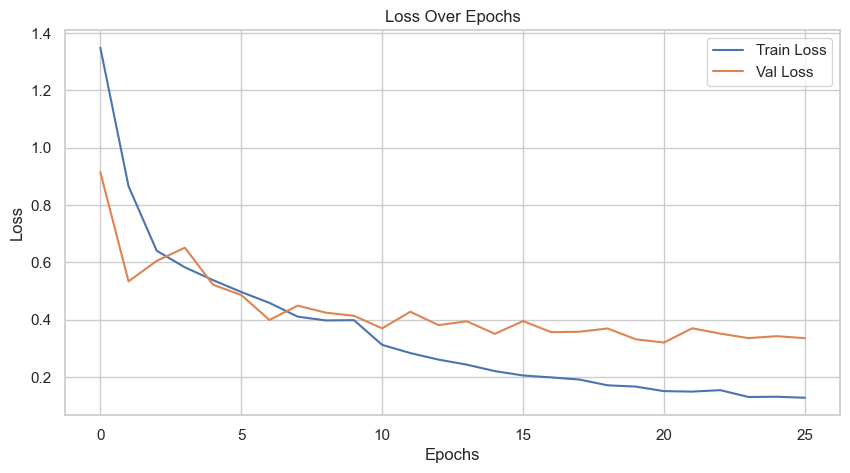

23/23 [==============================] - 3s 131ms/step

Classification Report:

                           precision    recall  f1-score   support

              Black-grass       0.48      0.51      0.49        39
                 Charlock       0.95      1.00      0.97        58
                 Cleavers       1.00      0.93      0.96        43
         Common Chickweed       0.93      0.99      0.96        92
             Common wheat       0.82      0.85      0.84        33
                  Fat Hen       0.96      0.96      0.96        72
         Loose Silky-bent       0.84      0.79      0.81        98
                    Maize       0.92      1.00      0.96        33
        Scentless Mayweed       0.95      0.96      0.96        78
          Shepherds Purse       0.93      0.79      0.86        34
Small-flowered Cranesbill       1.00      0.99      0.99        75
               Sugar beet       1.00      0.97      0.98        58

                 accuracy                      

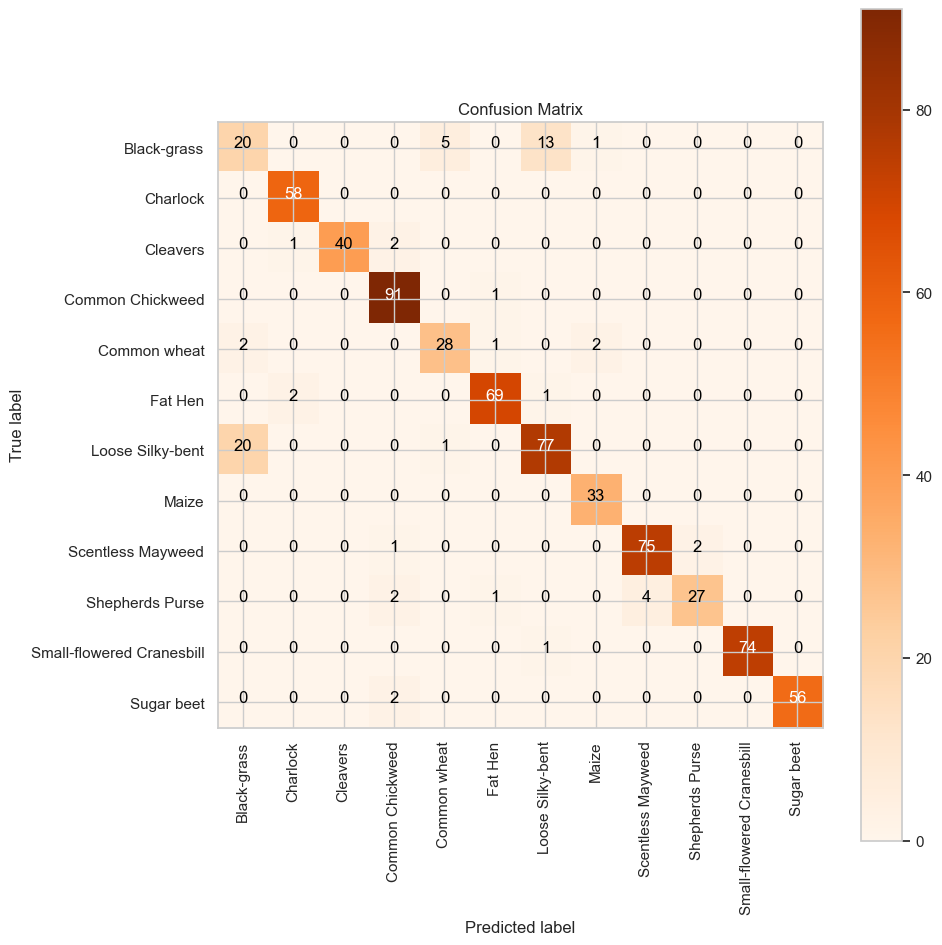

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import itertools

# --- Preprocess images for ResNet50 (expects 0-255 range) ---
X_train_ready = preprocess_input(X_train * 255.0)
X_val_ready = preprocess_input(X_val * 255.0)
X_test_ready = preprocess_input(X_test * 255.0)

# --- Model definition ---
input_shape = X_train_ready.shape[1:]
num_classes = y_train.shape[1]

base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))

# Unfreeze top 30 layers for fine-tuning
for layer in base_model.layers[:-30]:
    layer.trainable = False
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train_ready)

# Train
history_resnet = model.fit(
    datagen.flow(X_train_ready, y_train, batch_size=8),
    validation_data=(X_val_ready, y_val),
    epochs=30,
    callbacks=[early_stop, reduce_lr],
    steps_per_epoch=len(X_train_ready) // 8,
    verbose=1
)

# --- Plot training history ---
plt.figure(figsize=(10,5))
plt.plot(history_resnet.history['loss'], label='Train Loss')
plt.plot(history_resnet.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# --- Evaluation on test set ---
predY = model.predict(X_test_ready)
predYClasses = np.argmax(predY, axis=1)
trueY = np.argmax(y_test, axis=1)

# Confusion Matrix
confusionMTX = confusion_matrix(trueY, predYClasses)

# Class labels
index_to_label = {v: k for k, v in label_to_index.items()}
categ = [index_to_label[i] for i in range(len(index_to_label))]

# Plot Confusion Matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Oranges):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f'{cm[i, j]}',
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

plot_confusion_matrix(confusionMTX, classes=categ)

# --- Classification Report ---
print("\nClassification Report:\n")
print(classification_report(trueY, predYClasses, target_names=categ))
